# Image Segmentation Model - MONAI

##### Imports

In [1]:
import torch
import monai
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    LoadImaged,
    RandSpatialCrop,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.networks.nets import UNet
from monai.networks.blocks import Convolution
from monai.losses import DiceLoss
from monai.metrics import MeanIoU
from monai.data import CacheDataset, DataLoader, Dataset, ImageReader, MetaTensor
from monai.inferers import sliding_window_inference
from monai.transforms import Activations, AsDiscrete, KeepLargestConnectedComponent
from monai.visualize import plot_2d_or_3d_image
monai.utils.set_determinism(17)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os

from skimage.io import imread, imsave, imshow

from tqdm import tqdm

import datetime

##### Hyperparamters

In [2]:
batch_size = 4
num_workers = 4
learning_rate = 0.0005
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##### Dataset Creation

In [3]:
class CellDataset(Dataset):
    def __init__(self, data_dir, train=True):
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, 'image')
        self.mask_dir = os.path.join(data_dir, 'mask')
        self.image_files = os.listdir(self.image_dir)
        self.mask_files = os.listdir(self.mask_dir)
        self.transform_list = [
            RandFlip(prob=1, spatial_axis=0),
            RandFlip(prob=1, spatial_axis=1),
            RandRotate(prob=1, range_y=[1.57, 1.57]),
            RandRotate(prob=1, range_y=[4.71, 4.71])
        ]

        if train:
            self.image_files, self.test_image_files, self.mask_files, self.test_mask_files = train_test_split(
                self.image_files, self.mask_files, test_size=0.2, random_state=42)
        else:
            self.image_files, self.test_image_files, self.mask_files, self.test_mask_files = train_test_split(
                self.image_files, self.mask_files, test_size=0.2, random_state=42)
            self.image_files, self.test_image_files = self.test_image_files, self.image_files
            self.mask_files, self.test_mask_files = self.test_mask_files, self.mask_files
        
        self.temp_image_file = []
        self.temp_mask_file = []
        
        for image_path, mask_path in zip(self.image_files, self.mask_files):
            image_path = os.path.join(self.image_dir, image_path)
            mask_path = os.path.join(self.mask_dir, mask_path)
            image = MetaTensor(imread(image_path))
            mask = MetaTensor(imread(mask_path)).unsqueeze(0)
            self.temp_image_file.append(image)
            self.temp_mask_file.append(mask)
            for transform in self.transform_list:
                self.temp_image_file.append(transform(image))
                self.temp_mask_file.append(transform(mask))
        
        self.image_files, self.mask_files = self.temp_image_file, self.temp_mask_file

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):

        image = self.image_files[index].float()
        mask = torch.where(self.mask_files[index].float() == 0, 0.0, 1.0)

        return image, mask

In [4]:
class CellDataset(Dataset):
    def __init__(self, data_dir, mode='train'):
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, 'image')
        self.mask_dir = os.path.join(data_dir, 'mask')
        self.image_files_list = os.listdir(self.image_dir)
        self.mask_files_list = os.listdir(self.mask_dir)
        self.transform_list = [
            RandFlip(prob=1, spatial_axis=0),
            RandFlip(prob=1, spatial_axis=1),
            RandRotate(prob=1, range_y=[1.57, 1.57]),
            RandRotate(prob=1, range_y=[4.71, 4.71])
        ]

        train_image_files, val_image_files, test_image_files, train_mask_files, val_mask_files, test_mask_files = self.split_data_files()
        
        if mode == 'train':
            self.image_files, self.mask_files = train_image_files, train_mask_files
        elif mode == 'test':
            self.image_files, self.mask_files = test_image_files, test_mask_files
        elif mode == 'val':
            self.image_files, self.mask_files = val_image_files, val_mask_files
        
        self.temp_image_file = []
        self.temp_mask_file = []
        
        for image_path, mask_path in zip(self.image_files, self.mask_files):
            image_path = os.path.join(self.image_dir, image_path)
            mask_path = os.path.join(self.mask_dir, mask_path)
            image = MetaTensor(imread(image_path))
            mask = MetaTensor(imread(mask_path)).unsqueeze(0)
            self.temp_image_file.append(image)
            self.temp_mask_file.append(mask)
            for transform in self.transform_list:
                self.temp_image_file.append(transform(image))
                self.temp_mask_file.append(transform(mask))
        
        self.image_files, self.mask_files = self.temp_image_file, self.temp_mask_file

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):

        image = self.image_files[index].float()
        mask = torch.where(self.mask_files[index].float() == 0, 0.0, 1.0)

        return image, mask
    
    def split_data_files(self):
        train_image_files, rem_image_files, train_mask_files, rem_mask_files = train_test_split(self.image_files_list, self.mask_files_list, test_size=0.2, random_state=42)
        val_image_files, test_image_files, val_mask_files, test_mask_files = train_test_split(rem_image_files, rem_mask_files, test_size=0.5, random_state=42)
        return train_image_files, val_image_files, test_image_files, train_mask_files, val_mask_files, test_mask_files

In [5]:
DATA_DIR = '../data/segmentation_dataset/'
train_dataset = CellDataset(DATA_DIR, mode='train')
val_dataset = CellDataset(DATA_DIR, mode='val')
test_dataset = CellDataset(DATA_DIR, mode='test')

In [6]:
train_dataset.__len__(), val_dataset.__len__(), test_dataset.__len__()

(530, 65, 70)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_dataset, batch_size=4, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=4, pin_memory=torch.cuda.is_available())

In [8]:
len(train_loader), len(val_loader), len(test_loader)

(133, 17, 18)

##### Model Definition - UNet

In [9]:
in_channels = 8
out_channels = 1
model = UNet(
    spatial_dims=2,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
print(model)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

##### Loss Function and Optimizer

In [10]:
criterion = DiceLoss(sigmoid=True, jaccard=True)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

##### Training and Validation Loop

In [11]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Compute the loss
        loss = criterion(outputs, masks)
        # Backward pass and optimization
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, masks)

            test_loss += loss.item() * images.size(0)

        test_loss /= len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

  3%|▎         | 1/30 [00:11<05:42, 11.80s/it]

Epoch 1/30, Train Loss: 0.4633, Test Loss: 0.4048


  7%|▋         | 2/30 [00:19<04:14,  9.10s/it]

Epoch 2/30, Train Loss: 0.4103, Test Loss: 0.3623


 10%|█         | 3/30 [00:26<03:46,  8.38s/it]

Epoch 3/30, Train Loss: 0.3741, Test Loss: 0.3290


 13%|█▎        | 4/30 [00:34<03:29,  8.05s/it]

Epoch 4/30, Train Loss: 0.3455, Test Loss: 0.3045


 17%|█▋        | 5/30 [00:41<03:16,  7.86s/it]

Epoch 5/30, Train Loss: 0.3227, Test Loss: 0.2897


 20%|██        | 6/30 [00:48<03:04,  7.67s/it]

Epoch 6/30, Train Loss: 0.3068, Test Loss: 0.2768


 23%|██▎       | 7/30 [00:56<02:54,  7.59s/it]

Epoch 7/30, Train Loss: 0.2920, Test Loss: 0.2673


 27%|██▋       | 8/30 [01:03<02:47,  7.60s/it]

Epoch 8/30, Train Loss: 0.2819, Test Loss: 0.2647


 30%|███       | 9/30 [01:12<02:43,  7.77s/it]

Epoch 9/30, Train Loss: 0.2712, Test Loss: 0.2532


 33%|███▎      | 10/30 [01:20<02:41,  8.08s/it]

Epoch 10/30, Train Loss: 0.2612, Test Loss: 0.2543


 37%|███▋      | 11/30 [01:28<02:33,  8.09s/it]

Epoch 11/30, Train Loss: 0.2503, Test Loss: 0.2492


 40%|████      | 12/30 [01:37<02:27,  8.20s/it]

Epoch 12/30, Train Loss: 0.2398, Test Loss: 0.2458


 43%|████▎     | 13/30 [01:46<02:21,  8.32s/it]

Epoch 13/30, Train Loss: 0.2314, Test Loss: 0.2443


 47%|████▋     | 14/30 [01:54<02:14,  8.39s/it]

Epoch 14/30, Train Loss: 0.2230, Test Loss: 0.2424


 50%|█████     | 15/30 [02:03<02:06,  8.45s/it]

Epoch 15/30, Train Loss: 0.2138, Test Loss: 0.2416


 53%|█████▎    | 16/30 [02:12<02:00,  8.61s/it]

Epoch 16/30, Train Loss: 0.2067, Test Loss: 0.2406


 57%|█████▋    | 17/30 [02:20<01:52,  8.64s/it]

Epoch 17/30, Train Loss: 0.1999, Test Loss: 0.2404


 60%|██████    | 18/30 [02:30<01:45,  8.81s/it]

Epoch 18/30, Train Loss: 0.1946, Test Loss: 0.2461


 63%|██████▎   | 19/30 [02:39<01:38,  8.91s/it]

Epoch 19/30, Train Loss: 0.1904, Test Loss: 0.2377


 67%|██████▋   | 20/30 [02:48<01:31,  9.16s/it]

Epoch 20/30, Train Loss: 0.1851, Test Loss: 0.2370


 70%|███████   | 21/30 [02:57<01:21,  9.10s/it]

Epoch 21/30, Train Loss: 0.1804, Test Loss: 0.2386


 73%|███████▎  | 22/30 [03:06<01:12,  9.06s/it]

Epoch 22/30, Train Loss: 0.1779, Test Loss: 0.2346


 77%|███████▋  | 23/30 [03:16<01:05,  9.33s/it]

Epoch 23/30, Train Loss: 0.1745, Test Loss: 0.2362


 80%|████████  | 24/30 [03:26<00:56,  9.40s/it]

Epoch 24/30, Train Loss: 0.1712, Test Loss: 0.2396


 83%|████████▎ | 25/30 [03:36<00:47,  9.53s/it]

Epoch 25/30, Train Loss: 0.1680, Test Loss: 0.2372


 87%|████████▋ | 26/30 [03:46<00:38,  9.62s/it]

Epoch 26/30, Train Loss: 0.1653, Test Loss: 0.2356


 90%|█████████ | 27/30 [03:56<00:29,  9.87s/it]

Epoch 27/30, Train Loss: 0.1626, Test Loss: 0.2362


 93%|█████████▎| 28/30 [04:06<00:19, 10.00s/it]

Epoch 28/30, Train Loss: 0.1626, Test Loss: 0.2354


 97%|█████████▋| 29/30 [04:17<00:10, 10.09s/it]

Epoch 29/30, Train Loss: 0.1593, Test Loss: 0.2332


100%|██████████| 30/30 [04:27<00:00,  8.92s/it]

Epoch 30/30, Train Loss: 0.1585, Test Loss: 0.2352


In [12]:
# Save the trained model
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_name = f"segmentation_model_monai_{timestamp}.pth"
save_path = f"../models/segmentation_model/{model_name}"
torch.save(model.state_dict(), save_path)

##### Testing

In [13]:
metric = MeanIoU()
threshold_fn = AsDiscrete(threshold=0.5)

In [14]:
model.eval()
with torch.no_grad():
    metric.reset()
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = threshold_fn(Activations(sigmoid=True)(model(images)))
        metric(outputs, masks)
iou_score = metric.aggregate().item()
print(f"Test Dice score: {iou_score}")

Test Dice score: 0.7584258913993835


##### Visualization

In [15]:
image, mask = test_dataset.__getitem__(30)

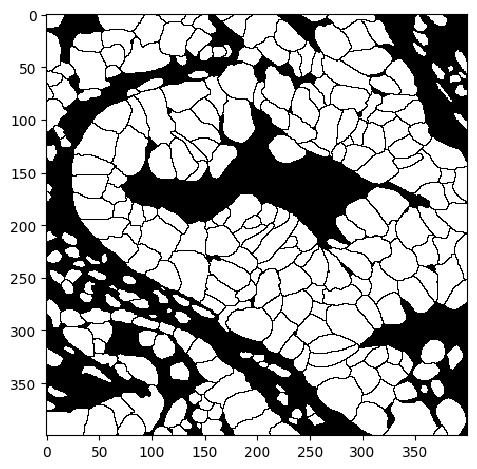

In [16]:
imshow(mask.squeeze().numpy(), cmap="gray")

In [17]:
sam_output = model(image.unsqueeze(0).to(device))

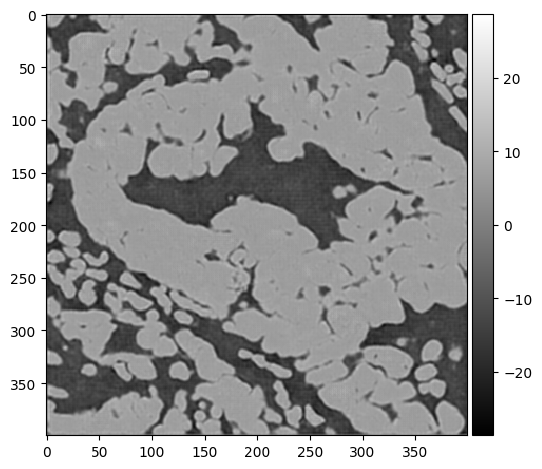

In [18]:
imshow(sam_output.squeeze().detach().cpu().numpy(), cmap="gray")

In [19]:
scaled_tensor = (sam_output - torch.min(sam_output)) * (1.0 / (torch.max(sam_output) - torch.min(sam_output)))

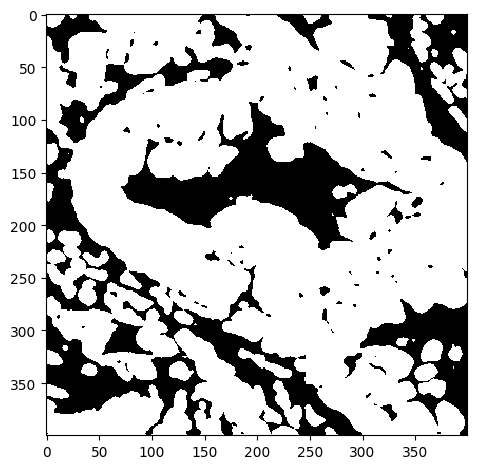

In [20]:
imshow(torch.round(scaled_tensor).detach().cpu().numpy().squeeze(), cmap='gray')